![](https://raw.githubusercontent.com/miquel-espinosa/COP-GEN-Beta/main/images/banner-github-simpler.png)

# [CVPR 2025] 🌍 COP-GEN-Beta: Generative Modelling of COPernicus Imagery Thumbnails

This notebook demonstrates how to use the COP-GEN-Beta model to generate satellite imagery across different modalities.
The model can perform various operations:
- Unconditional generation of all modalities
- Generation conditioned on one or more modalities

**Paper**: [COP-GEN-Beta: Unified Generative Modelling of COPernicus Imagery Thumbnails](https://www.arxiv.org/abs/2504.08548)

**Note**: This notebook is meant to run on Google Colab.

## 1. Setup the environment

First, we'll install the necessary dependencies and clone the repository.

In [ ]:
 %load_ext autoreload
%autoreload 2

In [ ]:
!pip install ml_collections
!git clone https://github.com/miquel-espinosa/COP-GEN-Beta.git
%cd COP-GEN-Beta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.2 MB/s eta 0:00:00
Cloning into 'COP-GEN-Beta'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 43 (delta 3), reused 38 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 17.02 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/COP-GEN-Beta


## 2. Download the pre-trained model

Download the pre-trained COP-GEN-Beta model weights to run inference, and Stable Diffusion frozen autoencoder.

In [ ]:
# Download stable diffusion encoder
!mkdir -p ./assets/stable-diffusion
!gdown --folder https://drive.google.com/drive/folders/1sV-IvcGUrZeIlTmtuKv9vDJiB4JEHL-f -O ./assets/stable-diffusion
# Create models directory if it doesn't exist and download pre-trained model
!mkdir -p models
!wget https://huggingface.co/mespinosami/COP-GEN-Beta/resolve/main/nnet_ema_114000.pth -O models/nnet_ema_114000.pth

Retrieving folder contents
Processing file 10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6 autoencoder_kl_ema.pth
Processing file 130Cq8uFKEqK8sgroIwN7hnRdNvB9DkCo autoencoder_kl.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6
From (redirected): https://drive.google.com/uc?id=10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6&confirm=t&uuid=40e8c741-7c1d-40d4-8b27-f56ae3705cc3
To: /content/COP-GEN-Beta/assets/stable-diffusion/autoencoder_kl_ema.pth
100% 335M/335M [00:04<00:00, 72.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=130Cq8uFKEqK8sgroIwN7hnRdNvB9DkCo
From (redirected): https://drive.google.com/uc?id=130Cq8uFKEqK8sgroIwN7hnRdNvB9DkCo&confirm=t&uuid=a1fbfe73-02a0-448e-8a51-6ea09340c417
To: /content/COP-GEN-Beta/assets/stable-diffusion/autoencoder_kl.pth
100% 335M/335M [00:05<00:00, 58.1MB/s]
Download completed
--2025-04-18 18:51:45

## 3. Import necessary libraries

Import libraries and utility functions


In [ ]:
import os
import torch
import utils
import numpy as np
from PIL import Image
import ml_collections
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from libs.autoencoder import get_model
import matplotlib.pyplot as plt
import einops
import random
import torchvision.transforms as standard_transforms
import libs
from dpm_solver_pp import DPM_Solver, NoiseScheduleVP
from sample_n_triffuser import set_seed, stable_diffusion_beta_schedule, unpreprocess

## 4. Define base config and model loading functions

In [ ]:
def get_config(generate_modalities, condition_modalities, seed):
    config = ml_collections.ConfigDict()
    config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    config.seed = seed
    config.n_samples = 1
    config.z_shape = (4, 32, 32)  # Shape of the latent vectors
    config.sample = {
        'sample_steps': 50,
        'algorithm': "dpm_solver",
    }
    # Model config
    config.num_modalities = 4  # 4 modalities: DEM, S1RTC, S2L1C, S2L2A
    config.modalities = ['dem', 's1_rtc', 's2_l1c', 's2_l2a']
    # Network config
    config.nnet = {
        'name': 'triffuser_multi_post_ln',
        'img_size': 32,
        'in_chans': 4,
        'patch_size': 2,
        'embed_dim': 1024,
        'depth': 20,
        'num_heads': 16,
        'mlp_ratio': 4,
        'qkv_bias': False,
        'pos_drop_rate': 0.,
        'drop_rate': 0.,
        'attn_drop_rate': 0.,
        'mlp_time_embed': False,
        'num_modalities': 4,
        'use_checkpoint': True,
    }

    # Parse generate and condition modalities
    config.generate_modalities = generate_modalities
    config.generate_modalities = sorted(config.generate_modalities, key=lambda x: config.modalities.index(x))
    config.condition_modalities = condition_modalities if condition_modalities else []
    config.condition_modalities = sorted(config.condition_modalities, key=lambda x: config.modalities.index(x))
    config.generate_modalities_mask = [mod in config.generate_modalities for mod in config.modalities]
    config.condition_modalities_mask = [mod in config.condition_modalities for mod in config.modalities]
    # Validate modalities
    valid_modalities = {'s2_l1c', 's2_l2a', 's1_rtc', 'dem'}
    for mod in config.generate_modalities + config.condition_modalities:
        if mod not in valid_modalities:
            raise ValueError(f"Invalid modality: {mod}. Must be one of {valid_modalities}")
    # Check that generate and condition modalities don't overlap
    if set(config.generate_modalities) & set(config.condition_modalities):
        raise ValueError("Generate and condition modalities must be different")
    # Default data paths
    config.nnet_path = 'models/nnet_ema_114000.pth'
    config.autoencoder = {"pretrained_path": "assets/stable-diffusion/autoencoder_kl_ema.pth"}

    return config

# Function to load model
def load_model(config):
    nnet = utils.get_nnet(**config.nnet)
    nnet.load_state_dict(torch.load(config.nnet_path, map_location=config.device))
    nnet.to(config.device)
    nnet.eval()

    autoencoder = libs.autoencoder.get_model(**config.autoencoder)
    # from diffusers.models import AutoencoderKL
    # autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
    autoencoder.to(config.device)
    autoencoder.eval()

    return nnet, autoencoder

## 5. Define inference functions


In [ ]:
# Function to prepare image for inference
def prepare_images(image_paths):
    transforms = standard_transforms.Compose([
                   standard_transforms.ToTensor(),
                   standard_transforms.Normalize(mean=(0.5,), std=(0.5,))
                 ])
    img_tensors = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img_tensors.append(transforms(img))  # Add batch dimension
    return img_tensors


def run_inference(config, nnet, autoencoder, img_tensors):
    set_seed(config.seed)
    img_tensors = [tensor.to(config.device) for tensor in img_tensors]
    # Create a context tensor for all modalities
    img_contexts = torch.randn(config.num_modalities, 1, 2 * config.z_shape[0],
                                config.z_shape[1], config.z_shape[2], device=config.device)
    with torch.no_grad():
        # Encode the input images with autoencoder
        z_conds = [autoencoder.encode_moments(tensor.unsqueeze(0)) for tensor in img_tensors]
        # Create mapping of conditional modalities indices to the encoded inputs
        cond_indices = [i for i, is_cond in enumerate(config.condition_modalities_mask) if is_cond]
        # Check if we have the right number of inputs
        if len(cond_indices) != len(z_conds):
            raise ValueError(f"Number of conditioning modalities ({len(cond_indices)}) must match number of input images ({len(z_conds)})")
        # Assign each encoded input to the corresponding modality
        for i, z_cond in zip(cond_indices, z_conds):
            img_contexts[i] = z_cond
    # Sample values from the distribution (mean and variance)
    z_imgs = torch.stack([autoencoder.sample(img_context) for img_context in img_contexts])
    # Generate initial noise for the modalities being generated
    _z_init = torch.randn(len(config.generate_modalities), 1, *z_imgs[0].shape[1:], device=config.device)

    def combine_joint(z_list):
        """Combine individual modality tensors into a single concatenated tensor"""
        return torch.concat([einops.rearrange(z_i, 'B C H W -> B (C H W)') for z_i in z_list], dim=-1)

    def split_joint(x, z_imgs, config):
        """
        Split the combined tensor back into individual modality tensors
        and arrange them according to the full set of modalities
        """
        C, H, W = config.z_shape
        z_dim = C * H * W
        z_generated = x.split([z_dim] * len(config.generate_modalities), dim=1)
        z_generated = {modality: einops.rearrange(z_i, 'B (C H W) -> B C H W', C=C, H=H, W=W)
                    for z_i, modality in zip(z_generated, config.generate_modalities)}
        z = []
        for i, modality in enumerate(config.modalities):
            if modality in config.generate_modalities: # Modalities that are being denoised
                z.append(z_generated[modality])
            elif modality in config.condition_modalities: # Modalities that are being conditioned on
                z.append(z_imgs[i])
            else: # Modalities that are ignored
                z.append(torch.randn(x.shape[0], C, H, W, device=config.device))

        return z

    _x_init = combine_joint(_z_init) # Initial tensor for the modalities being generated
    _betas = stable_diffusion_beta_schedule()
    N = len(_betas)

    def model_fn(x, t_continuous):
        t = t_continuous * N

        # Create timesteps for each modality based on the generate mask
        timesteps = [t if mask else torch.zeros_like(t) for mask in config.generate_modalities_mask]
        # Split the input into a list of tensors for all modalities
        z = split_joint(x, z_imgs, config)
        # Call the network with the right format
        z_out = nnet(z, t_imgs=timesteps)
        # Select only the generated modalities for the denoising process
        z_out_generated = [z_out[i]
                        for i, modality in enumerate(config.modalities)
                        if modality in config.generate_modalities]
        # Combine the outputs back into a single tensor
        return combine_joint(z_out_generated)

    # Sample using the DPM-Solver with exact parameters from sample_n_triffuser.py
    noise_schedule = NoiseScheduleVP(schedule='discrete', betas=torch.tensor(_betas, device=config.device).float())
    dpm_solver = DPM_Solver(model_fn, noise_schedule, predict_x0=True, thresholding=False)

    # Generate samples
    with torch.no_grad():
        with torch.autocast(device_type=config.device):
            x = dpm_solver.sample(_x_init, steps=config.sample.sample_steps, eps=1. / N, T=1.)

    # Split the result back into individual modality tensors
    _zs = split_joint(x, z_imgs, config)

    # Replace conditional modalities with the original images
    for i, mask in enumerate(config.condition_modalities_mask):
        if mask:
            _zs[i] = z_imgs[i]

    # Decode and unprocess the generated samples
    generated_samples = []
    for i, modality in enumerate(config.modalities):
        if modality in config.generate_modalities:
            sample = autoencoder.decode(_zs[i]) # Decode the latent representation
            sample = unpreprocess(sample) # Unpreprocess to [0, 1] range
            generated_samples.append((modality, sample))

    return generated_samples

## 6. Custom inference wrapper

To run inference with COP-GEN-Beta, we need to provide the following parameters:
- `generate_modalities`: List of modalities to generate
- `ondition_modalities`: List of modalities to condition on
- `seed`: Fix seed for reproducibility, otherwise a random seed will be used
- `image_paths`: Path to conditioning image or list of paths (ordered to match condition_modalities)
- `visualize`: Whether to show the generated images inline in the notebook (default: True)


In [ ]:
def custom_inference(generate_modalities, condition_modalities, seed=None, image_paths=None, visualize=True):
    """
    Run custom inference with user-specified parameters

    Args:
        generate_modalities: List of modalities to generate
        condition_modalities: List of modalities to condition on
        image_paths: Path to conditioning image or list of paths (ordered to match condition_modalities)
        visualize: Whether to show the generated images (default: True)

    Returns:
        Dict mapping modality names to generated tensors
    """
    if seed is None:
        seed = random.randint(0, 1000000)

    config = get_config(generate_modalities, condition_modalities, seed=seed)
    nnet, autoencoder = load_model(config)

    # Checks
    if image_paths is None and condition_modalities:
        raise ValueError("Must provide image_paths when conditioning on modalities")
    if condition_modalities:
        if isinstance(image_paths, str):
            if len(condition_modalities) > 1:
                raise ValueError(f"Number of image paths ({1}) must match number of conditioning modalities ({len(condition_modalities)})")
        elif len(image_paths) != len(condition_modalities):
            raise ValueError(f"Number of image paths ({len(image_paths)}) must match number of conditioning modalities ({len(condition_modalities)})")

    img_tensors = prepare_images(image_paths) if image_paths is not None else []
    for el in img_tensors:
      print(el.shape)

    generated_samples = run_inference(config, nnet, autoencoder, img_tensors)
    results = {modality: tensor for modality, tensor in generated_samples}

    # Visualize the results
    if visualize:
        n_cols = len(condition_modalities) + len(generate_modalities)
        plt.figure(figsize=(n_cols * 4, 5))

        # First show the conditioning image(s)
        for i, modality in enumerate(condition_modalities):
            plt.subplot(1, n_cols, i + 1)
            img_path = image_paths[i]
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Conditioning\n({modality.upper()})")
            plt.axis('off')

        # Then show the generated images
        for i, modality in enumerate(generate_modalities):
            col = len(condition_modalities) + i + 1
            plt.subplot(1, n_cols, col)
            sample = results[modality]
            img = sample.cpu().squeeze().permute(1, 2, 0).numpy()
            plt.imshow(img)
            plt.title(f"Generated\n({modality.upper()})")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    return results

## 7. Generate images

Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
torch.Size([3, 256, 256])


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


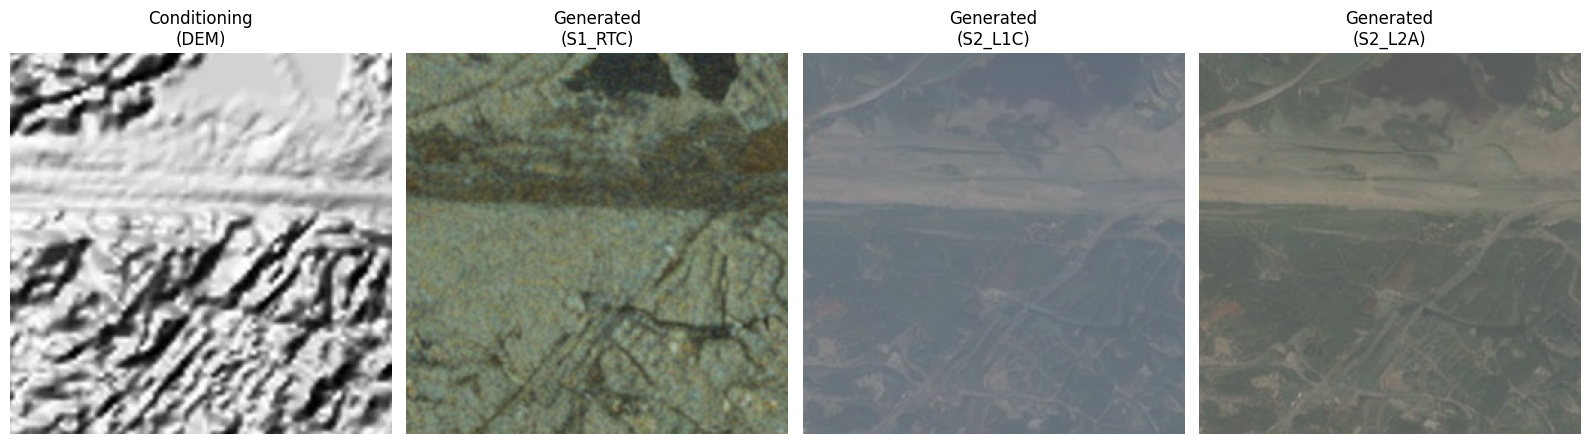

Generated modalities: ['s1_rtc', 's2_l1c', 's2_l2a']
Tensor shape for s1_rtc: torch.Size([1, 3, 256, 256])


In [ ]:
# Example 1: Generate multiple modalities conditioned on a single modality
imgs_1 = custom_inference(
    generate_modalities=['s1_rtc', 's2_l1c', 's2_l2a'],
    condition_modalities=['dem'],
    image_paths=['input_images/dem.webp'],
    seed=41
)
print(f"Generated modalities: {list(imgs_1.keys())}")
print(f"Tensor shape for s1_rtc: {imgs_1['s1_rtc'].shape}")

Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


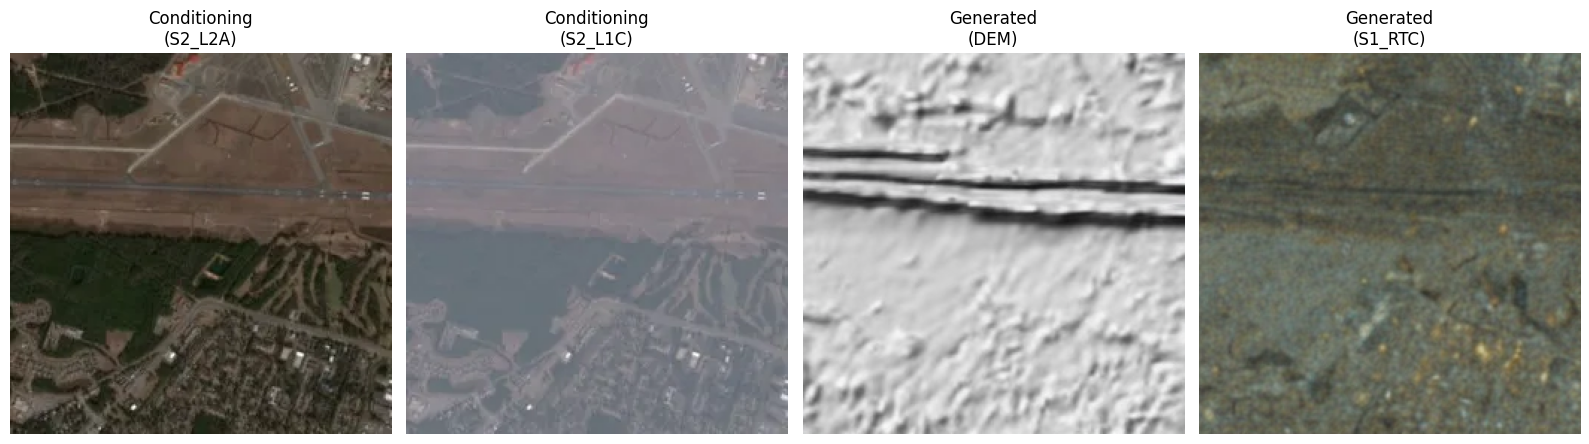

Generated modalities: ['dem', 's1_rtc']


In [ ]:
# Example 2: Generate modalities conditioned on multiple modalities
imgs_2 = custom_inference(
    generate_modalities=['dem', 's1_rtc'],
    condition_modalities=['s2_l2a', 's2_l1c'],
    image_paths=['input_images/s2l2a.webp', 'input_images/s2l1c.webp'],
    seed=4200
)
print(f"Generated modalities: {list(imgs_2.keys())}")

Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


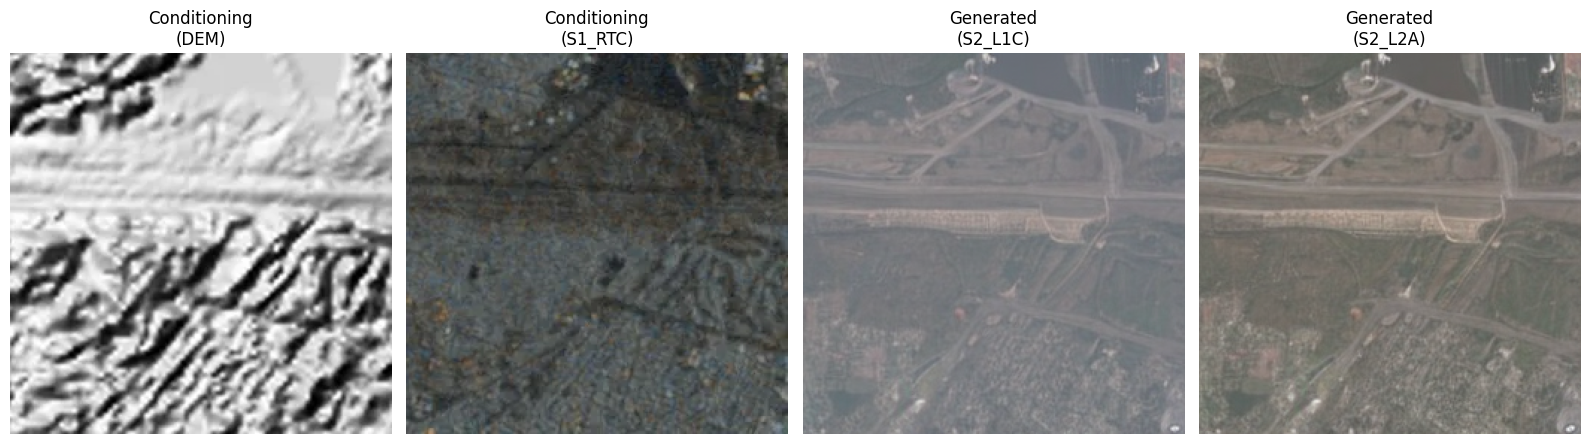

Generated modalities: ['s2_l1c', 's2_l2a']


In [ ]:
# Example 2.1: Generate modalities conditioned on multiple modalities
imgs_2 = custom_inference(
    generate_modalities=['s2_l1c', 's2_l2a'],
    condition_modalities=['dem','s1_rtc'],
    image_paths=['input_images/dem.webp', 'input_images/s1rtc.webp'],
    seed=42
)
print(f"Generated modalities: {list(imgs_2.keys())}")

Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


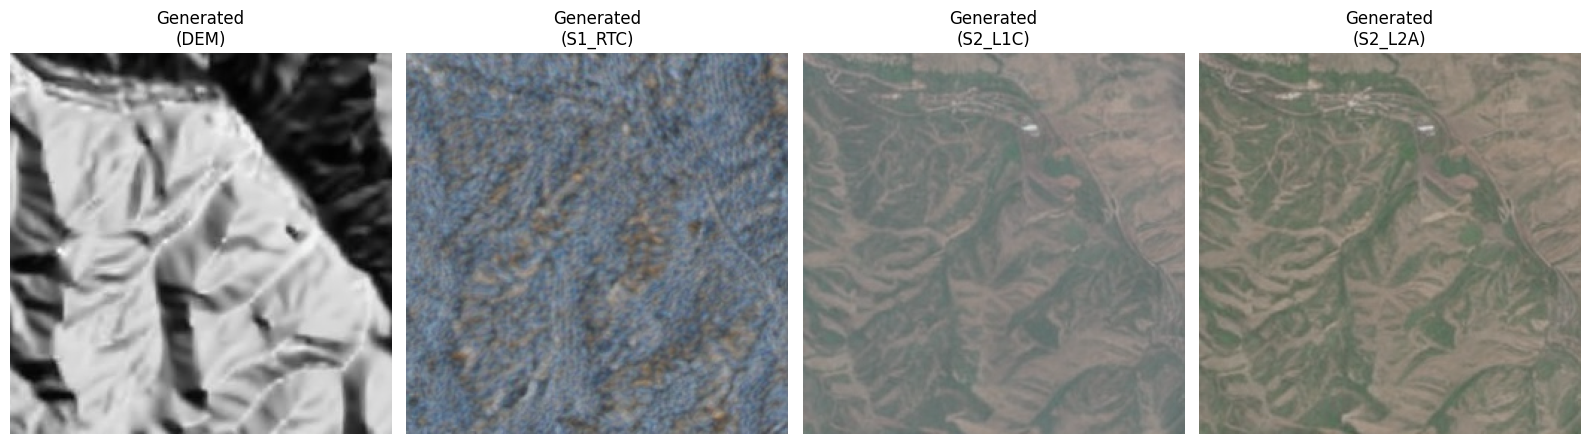

Generated modalities (unconditional): ['dem', 's1_rtc', 's2_l1c', 's2_l2a']


In [ ]:
# Example 3: Unconditional generation of all modalities (no input images needed)
imgs_3 = custom_inference(
    generate_modalities=['dem', 's1_rtc', 's2_l1c', 's2_l2a'],
    condition_modalities=[],
    seed=42
)
print(f"Generated modalities (unconditional): {list(imgs_3.keys())}")

In [ ]:
# Example 4: Generate images without visualizing them
imgs_4 = custom_inference(
    generate_modalities=['s2_l1c', 's2_l2a'],
    condition_modalities=['dem', 's1_rtc'],
    image_paths=['input_images/dem.webp', 'input_images/s1rtc.webp'],
    seed=42,
    visualize=False
)
print(f"Generated modalities (no visualization): {list(imgs_4.keys())}")

Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Generated modalities (no visualization): ['s2_l1c', 's2_l2a']
